In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import string
from shutil import copyfile, rmtree
import re
import cv2
from PIL import Image, ImageDraw
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda
import tensorflow.keras.backend as K


sets = ['set_a', 'set_b','set_c']



def get_Word(name):
    file_name = name.split("/")[-1].split(".")[0]
    load_profile = open('/'.join(name.split('/')[:len(name.split('/'))-2]) + "/tru/" +file_name + ".tru", "r")
    #for T in os.listdir(chemin):
    #path = chemin + '/' + T
    label = load_profile.read().splitlines()[6]
    word = re.search(r"AW2:(.*?);", label).group(1).split('|')[:-1]
    #if len(word) == 0 : print(path_gt)
    return word
    #path_gt =  "C:/Users/pc/Documents/DEGILA_Elysee/Cours UEMF 2/OCR_/ifnenit_v2.0p1e/data" + "/" +file_name + ".tru"


def evaluate_word(name):
    word = get_Word(name)
    for i, car in enumerate(word):
        if car[-1] == "1" or car[-1] == "2":
            word[i] = "-"
    return word

def get_lexicon_2(names):
    arabic_labels = []
    for name in names:
        arabic_labels = arabic_labels + evaluate_word(name)
    return list(dict.fromkeys(arabic_labels))

def get_lengths(names):
    d = {}
    for name in names:
        file_name = name.split("/")[-1].split(".")[0]
        word = get_Word(name)
        d[file_name] = len(word)
    return d

def open_image(name, img_size=[100, 300]):
    img = cv2.imread(name, 0)
    img = cv2.resize(img, (img_size[1], img_size[0]), Image.LANCZOS)
    img = cv2.threshold(img, 255 // 2, 255, cv2.THRESH_BINARY)[1]
    img = cv2.bitwise_not(img)
    word = get_Word(name)
    return img, word



class Readf:
    def __init__(self, img_size=(300, 100), max_len=17, normed=False, batch_size=64, classes={}, mean=118.2423, std=36.72):
        self.batch_size = batch_size
        self.img_size = img_size
        self.normed = normed
        self.classes = classes
        self.max_len = max_len
        self.mean = mean
        self.std = std
        self.voc = list(self.classes.keys())

        if type(classes) == dict:
            self.blank = classes["-"]

    def make_target(self, text):
        return np.array([self.classes[char] if char in self.voc else self.classes['-'] for char in text])

    def get_labels(self, names):
        Y_data = np.full([len(names), self.max_len], self.blank)
        for i, name in enumerate(names):
            img, word = open_image(name, self.img_size)
            word = self.make_target(word)
            Y_data[i, 0:len(word)] = word
        return Y_data

    def get_blank_matrices(self):
        shape = (self.batch_size,) + self.img_size
        X_data = np.empty(shape)
        Y_data = np.full([self.batch_size, self.max_len], self.blank)
        input_length = np.ones((self.batch_size, 1))
        label_length = np.zeros((self.batch_size, 1))
        return X_data, Y_data, input_length, label_length
    
    def run_generator(self, names, downsample_factor=4):
        n_instances = len(names)
        N = n_instances // self.batch_size
        rem = n_instances % self.batch_size
    
        while True:
            X_data, Y_data, input_length, label_length = self.get_blank_matrices()
    
            i, n = 0, 0
            for name in names:
                img, word = open_image(name, self.img_size)
                word = self.make_target(word)
    
                if len(word) == 0:
                    continue
    
                Y_data[i, 0:len(word)] = word
                label_length[i] = len(word)
                input_length[i] = self.img_size[1] // downsample_factor  # Adjust downsample factor accordingly
    
                img = np.transpose(img, (1, 0))
                img = cv2.resize(img, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_AREA)
                X_data[i, :, :] = img
    
                i += 1
    
                if i == self.batch_size:
                    n += 1
                    #print("Batch shapes:", X_data.shape, Y_data.shape, input_length.shape, label_length.shape)
                    inputs = {
                        'the_input': X_data,
                        'the_labels': Y_data,
                        'input_length': input_length,
                        'label_length': label_length,
                    }
                    outputs = {'ctc': np.zeros([self.batch_size])}
                    yield (inputs, outputs)

                    X_data, Y_data, input_length, label_length = self.get_blank_matrices()
                    i = 0
    
            if rem > 0:
                inputs = {
                    'the_input': X_data[:rem],
                    'the_labels': Y_data[:rem],
                    'input_length': input_length[:rem],
                    'label_length': label_length[:rem],
                }
                outputs = {'ctc': np.zeros([rem])}
                yield (inputs, outputs)

        
    


class CRNN:
    def __init__(self, img_w, img_h, output_size, max_len):
        self.img_w = img_w
        self.img_h = img_h
        self.output_size = output_size
        self.max_len = max_len

        # Network parameters
        self.conv_filters = 128
        self.kernel_size = (3, 3)
        self.pool_size = 2
        self.time_dense_size = 64
        self.rnn_size = 512

        self.model = self.build_model()

    def ctc_lambda_func(self, args):
        y_pred, labels, input_length, label_length = args
        #y_pred = y_pred[:, 2:, :]

        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    def build_model(self):
        input_data = Input(name='the_input', shape=(self.img_w, self.img_h), dtype='float32')
        expanded_input = Lambda(lambda x: K.expand_dims(x, axis=-1))(input_data)
        
        conv_1 = Conv2D(self.conv_filters, self.kernel_size, padding='same', activation='relu', name='conv1')(expanded_input)
        pool_1 = MaxPooling2D(pool_size=(self.pool_size, self.pool_size), name='pool1')(conv_1)
        
        conv_2 = Conv2D(self.conv_filters, self.kernel_size, padding='same', activation='relu', name='conv2')(pool_1)
        pool_2 = MaxPooling2D(pool_size=(self.pool_size, self.pool_size), name='pool2')(conv_2)
        
        conv_to_rnn_dims = (self.img_w // (self.pool_size * 2), self.img_h // (self.pool_size * 2) * self.conv_filters)
        reshaped = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(pool_2)
        
        dense = Dense(self.time_dense_size, activation='relu', name='dense')(reshaped)
        
        rnn = Bidirectional(LSTM(self.rnn_size, return_sequences=True), name='biLSTM')(dense)
        
        y_pred = Dense(self.output_size, activation='softmax', name='softmax')(rnn)
        
        labels = Input(name='the_labels', shape=[self.max_len], dtype='float32')
        input_length = Input(name='input_length', shape=[1], dtype='int64')
        label_length = Input(name='label_length', shape=[1], dtype='int64')
        
        ctc_loss = Lambda(self.ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
        
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=[ctc_loss, y_pred])
        model.summary()

        return model
        

C:\Users\Asus ROG\Desktop\Second year engineer\s8\ocr\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data/set_a/tif/ae07_001.tif


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 300, 100)]           0         []                            
                                                                                                  
 lambda (Lambda)             (None, 300, 100, 1)          0         ['the_input[0][0]']           
                                                                                                  
 conv1 (Conv2D)              (None, 300, 100, 128)        1280      ['lambda[0][0]']              
                                                                                                  
 pool1 (MaxPooling2D)        (None, 150, 50, 128)         0 

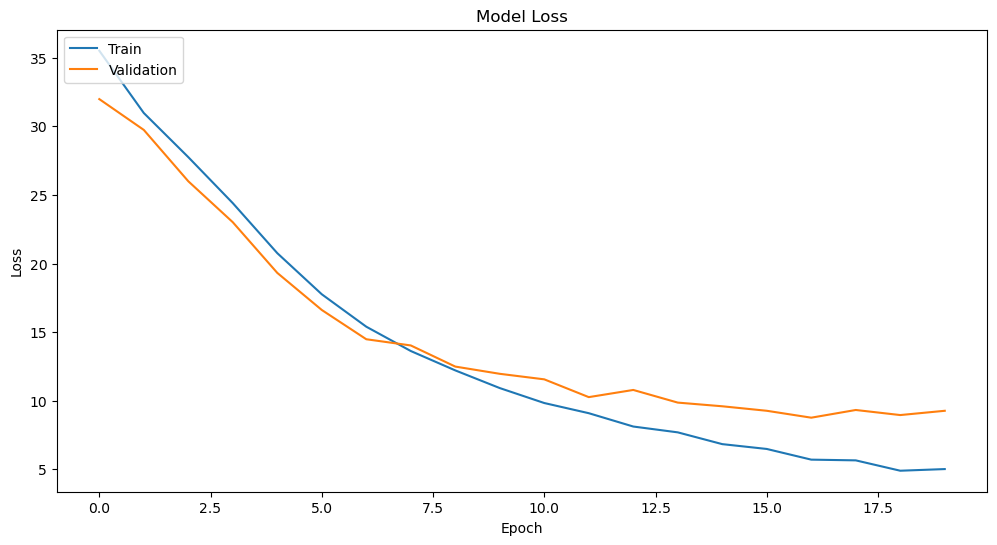

In [2]:
#from untitled1 import *
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import RandomState
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import string
from shutil import copyfile, rmtree
import re
import cv2
from PIL import Image, ImageDraw
import glob
from keras.callbacks import EarlyStopping


save_path = r"C:\Users\Asus ROG\Desktop\Second year engineer\s8\ocr"
path = r"C:\Users\Asus ROG\Desktop\Second year engineer\s8\ocr\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data"
model_name = "OCR_IFNENIT"

prng = RandomState(32)


batch_size = 128 # CHANGER BATCH 
imgh = 100
imgw = 300

try:
    rmtree(save_path + "/" + model_name)
except:
    pass

os.mkdir(save_path + "/" + model_name)

train = []
lexicon = []
for set in sets:
    PATH = path + '/' + set + '/' + 'tif'
    train.extend([dp + "/" + f for dp, dn, filenames in os.walk(PATH) for f in filenames if re.search('tif', f)])

print(train[0])
#train = [dp + "/" + f for dp, dn, filenames in os.walk(path)
 #        for f in filenames if re.search('tif', f)]


prng.shuffle(train)
lexicon = get_lexicon_2(train)
classes = {j: i for i, j in enumerate(lexicon)}
inve_classes = {v: k for k, v in classes.items()}

length = len(train)
train, val = train[:int(length * 0.9)], train[int(length * 0.9):]
lenghts = get_lengths(train)
max_len = max(lenghts.values())

objet = Readf(classes=classes)



img_w1= 300
img_h1 = 100
output_size = len(classes) +1
crnn = CRNN(img_w1, img_h1, output_size, max_len)
model = crnn.model

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

train_generator = objet.run_generator(train)
val_generator = objet.run_generator(val)

train_steps = len(train) // batch_size
val_steps = len(val) // batch_size + 1

for i in range(1, 5):  # Aller jusqu'au quatrième lot
    inputs, _ = next(train_generator)
    if i == 4:  # Si c'est le quatrième lot
        batch_length = len(inputs['the_input'])  # Obtenir la longueur du batch
        

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=100,
    callbacks=[early_stopping]
)




# Create empty arrays to store the evaluation results


losses = []

# Iterate over the validation generator and calculate loss for each batch
for i in range(val_steps):
    inputs, targets = next(val_generator)
    loss = model.evaluate(inputs, targets, verbose=0)
    losses.append(loss)

# Calculate the average validation loss
validation_loss = np.mean(losses)

# Print the evaluation result
print("Validation Loss:", validation_loss)



# Call the plot_training_history function
def plot_training_history(history):
    import matplotlib.pyplot as plt
    
   
    plt.figure(figsize=(12, 6))
    # A dictionary containing the recorded values of different metrics during training
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_training_history(history)



In [8]:
def preprocess_image(image_path, img_size=(300, 100)):
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_LANCZOS4)
    img = cv2.threshold(img, 255 // 2, 255, cv2.THRESH_BINARY)[1]
    img = cv2.bitwise_not(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def decode_prediction(pred, chars):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    decoded_texts = []
    for d in decoded:
        decoded_texts.append(''.join([chars[char] for char in d.numpy() if char != -1]))
    return decoded_texts

# Create the inference model
input_data = Input(name='the_input', shape=(img_w1,img_h1), dtype='float32')
y_pred = model.get_layer('softmax').output

inference_model = Model(inputs=model.input[0], outputs=y_pred)

# Example usage
image_path = r"C:\Users\Asus ROG\Desktop\Second year engineer\s8\ocr\ifnenit-database-demo\data\set_a\tif\af03_007.tif"
preprocessed_image = preprocess_image(image_path)
prediction = inference_model.predict(preprocessed_image)

decoded_texts = decode_prediction(prediction, inve_classes)
print('Predicted Text:', decoded_texts[0])

1/1 [==============================] - 1s 760ms/step
Predicted Text: naBraEllLraE


In [ ]:
##best path decodig

In [25]:
model.save(save_path + "/" + model_name+ "/ocr1_model.h5")


def num_to_label(num, inv_classes):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            char = inv_classes.get(ch)
            if char is not None:  # Check if the character exists in the mapping
                ret += char
    return ret



# Create empty arrays to store the predictions
predictions_ctc_loss = []
predictions_probabilities = []

# Iterate over the validation generator and make predictions for each batch
for i in range(val_steps):
    inputs, _ = next(val_generator)

    # Reshape the input images to match the expected shape of the model
    inputs['the_input'] = inputs['the_input'].reshape((-1, imgw, imgh))

    # Make predictions with the model
    batch_ctc_loss, batch_predictions = model.predict(inputs)

    predictions_ctc_loss.append(batch_ctc_loss)
    predictions_probabilities.append(batch_predictions)

# Concatenate the predictions for all batches
predictions_ctc_loss = np.concatenate(predictions_ctc_loss, axis=0)
predictions_probabilities = np.concatenate(predictions_probabilities, axis=0)


#Best-path decoding
decoded = K.get_value(K.ctc_decode(predictions_probabilities, 
                                   input_length=np.ones(predictions_probabilities.shape[0])*predictions_probabilities.shape[1], 
                                   greedy=False)[0][0])

decoded_words = []
for d in decoded:
    decoded_word = num_to_label(d, inve_classes)
    decoded_words.append(decoded_word)
    

true_words = []  # List to store the true words

# Iterate over the validation set
for image_path in val:
    true_word = evaluate_word(image_path)  # Get the true word for the current image
    true_words.append(true_word)
# Compare the true words with the decoded words
for true_word, decoded_word in zip(true_words, decoded_words):
    true_word1 = ''.join(true_word)
    if true_word1 == decoded_word:
        print("Correct: ", true_word)
    else:
        print("Incorrect: True word =", true_word , ", Decoded word =", decoded_word)




C:\Users\Asus ROG\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 1s 360ms/step
Incorrect: True word = ['aaA', 'haMlaB', 'aaE', 'maBllL', 'teE'] , Decoded word = aeAkeBllLwaEdaAteA
Incorrect: True word = ['aaA', 'laB', 'ghM', 'raE', 'aaA', 'baB', 'toE'] , Decoded word = taBlaEllLlaBghMzaEaaElaB
Incorrect: True word = ['taB', 'laE', 'aaA', 'laB', 'ghM', 'zaE', 'aaElaB', 'naA'] , Decoded word = aaAlaBraEhaByaMshE
Incorrect: True word = ['-', 'toM', 'naM', 'aaE', 'seB', 'teE'] , Decoded word = shBmaMllLaaEkhA
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'faB', 'taM', 'haE', 'aaA', 'laB', 'laMllL', 'heE'] , Decoded word = taByaMkhBaaAlaBdaEllLyaBnaE
Incorrect: True word = ['haB', 'aaE', 'maBllL', 'teE', 'aaA', 'laB', 'jaM', 'raE', 'yaB', 'daE'] , Decoded word = aaAlaBmaMraEnaBaaEkaByaMllL0A2AmaBaaEseA
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'baB', 'waE', 'baB', 'keMllL', 'raE'] , Decoded word = haByaEaaElaBdaAaaAlaBheMaaEdaA
Incorrect: True word = ['seB', 'baM', 'ayM', 'teE', 'amA', 'baB', 'aaE', 

In [18]:
import numpy as np
import keras.backend as K
import Levenshtein

def beam_search_decoder(probabilities, beam_width):
    # Initialize beam with empty sequence and probability 1
    beam = [([], 1.0)]
    
    # Iterate through each time step
    for prob_step in probabilities:
        new_beam = []
        
        # Expand each candidate in the beam
        for prefix, prefix_prob in beam:
            # Get the top-k most probable characters at the current time step
            top_chars = np.argsort(prob_step)[-beam_width:]
            
            # Add each character to the candidate list
            for char in top_chars:
                new_sequence = prefix + [char]
                new_prob = prefix_prob * prob_step[char]
                new_beam.append((new_sequence, new_prob))
        
        # Select top-k candidates from the expanded list
        new_beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
        beam = new_beam
    
    # Return the sequence with the highest probability
    best_sequence, best_prob = beam[0]
    return best_sequence

def num_to_label(num, inv_classes):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            char = inv_classes.get(ch)
            if char is not None:  # Check if the character exists in the mapping
                ret += char
    return ret

# Create empty arrays to store the predictions
predictions_ctc_loss = []
predictions_probabilities = []

# Iterate over the validation generator and make predictions for each batch
for i in range(val_steps):
    inputs, _ = next(val_generator)
    inputs['the_input'] = inputs['the_input'].reshape((-1, imgw, imgh))
    batch_ctc_loss, batch_predictions = model.predict(inputs)
    predictions_ctc_loss.append(batch_ctc_loss)
    predictions_probabilities.append(batch_predictions)

predictions_ctc_loss = np.concatenate(predictions_ctc_loss, axis=0)
predictions_probabilities = np.concatenate(predictions_probabilities, axis=0)

# Decode the predictions using beam search
beam_width = 1
decoded_words = []
for prediction in predictions_probabilities:
    decoded_sequence = beam_search_decoder(prediction, beam_width)
    decoded_word = num_to_label(decoded_sequence, inve_classes)
    decoded_words.append(decoded_word)

true_words = []  # List to store the true words
for image_path in val:
    true_word = evaluate_word(image_path)  # Get the true word for the current image
    true_words.append(true_word)

# Function to find the most similar word based on Levenshtein distance
def find_most_similar_word(pred_word, true_words):
    min_distance = float('inf')
    most_similar_word = ""
    for word in true_words:
        true_word1 = ''.join(word)
        distance = Levenshtein.distance(pred_word, true_word1)
        if distance < min_distance:
            min_distance = distance
            most_similar_word = word
    return most_similar_word

# Compare the true words with the decoded words
compte1=0;
compte2=0;
for true_word, decoded_word in zip(true_words, decoded_words):
    true_word1 = ''.join(true_word)
    corrected_word = find_most_similar_word(decoded_word, true_words)
    corrected_word1 = ''.join(corrected_word)
    if true_word1 == decoded_word:
        print("Correct: ", true_word)
        compte1=compte1+1
    elif true_word1 == corrected_word1:
        print("correct: True word =", true_word )
        compte1=compte1+1
    else:
        print("Incorrect: True word =", true_word , ", Decoded word =", corrected_word)
        compte2=compte2+1

2/2 [==============================] - 1s 403ms/step
Incorrect: True word = ['aaA', 'haMlaB', 'aaE', 'maBllL', 'teE'] , Decoded word = ['baB', 'laM', 'yaM', 'aaE', 'naB', 'teE']
correct: True word = ['aaA', 'laB', 'ghM', 'raE', 'aaA', 'baB', 'toE']
correct: True word = ['taB', 'laE', 'aaA', 'laB', 'ghM', 'zaE', 'aaElaB', 'naA']
Incorrect: True word = ['-', 'toM', 'naM', 'aaE', 'seB', 'teE'] , Decoded word = ['taB', 'maM', 'raE', 'teA']
correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'faB', 'taM', 'haE', 'aaA', 'laB', 'laMllL', 'heE']
Incorrect: True word = ['haB', 'aaE', 'maBllL', 'teE', 'aaA', 'laB', 'jaM', 'raE', 'yaB', 'daE'] , Decoded word = ['haB', 'aaE', 'maBllL', 'teE', 'aaA', 'jaMlaB', 'raE', 'yaB', 'daE']
correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'baB', 'waE', 'baB', 'keMllL', 'raE']
correct: True word = ['seB', 'baM', 'ayM', 'teE', 'amA', 'baB', 'aaE', 'raA']
correct: True word = ['taB', 'aaElaM', 'baB', 'taE']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khBllL', 

correct: True word = ['aaA', 'laB', 'faM', 'keMllL', 'teE']
correct: True word = ['maB', 'raE', 'faB', 'kaE', 'aaA', 'laB', 'faM', 'raE', 'yaB', 'waE']
Incorrect: True word = ['haB', 'laM', 'kaE', 'aaA', 'laB', 'jaM', 'maM', 'laE'] , Decoded word = ['haB', 'maM', 'aaE', 'daA', 'yaA', 'aaA', 'laB', 'kaM', 'baM', 'laM', 'yaE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'keM', 'naM', 'aaE', 'seBllL', 'yaE'] , Decoded word = ['aaA', 'laB', 'maM', 'laM', 'kaM', 'eeE']
correct: True word = ['taB', 'toM', 'aaE', 'waA', 'yaB', 'naE', '7A', 'naB', 'waE', 'faB', 'maM', 'baM', 'raE']
Incorrect: True word = ['aaA', 'laB', 'faM', 'aaE', 'yaB', 'deE'] , Decoded word = ['aaA', 'laB', 'kaM', 'saM', 'raE', 'aaA', 'laB', 'jaM', 'daE', 'yaB', 'daE']
correct: True word = ['jaB', 'baM', 'laE', 'aaA', 'laB', 'raE', 'saB', 'aaE', '-']
Incorrect: True word = ['haB', 'yaE', 'aaA', 'maMlaB', 'heM', 'yaM', 'raE', 'yaA'] , Decoded word = ['taB', 'aaElaM', 'baB', 'taE']
correct: True word = ['aaA', 'laB', 'faM',

Incorrect: True word = ['aaA', 'laB', 'faM', 'aaE', 'yaB', 'deE'] , Decoded word = ['aaA', 'laB', 'seM', 'aaE', 'haB', 'laM', 'yaM', 'naE']
correct: True word = ['aeA', 'maA', 'aaA', 'laB', 'ayM', 'zaM', 'aaE', 'maA']
correct: True word = ['aaA', 'laB', 'dhE', 'waA', 'yaB', 'baM', 'aaE', 'taA']
Incorrect: True word = ['baB', 'laM', 'yaM', 'aaE', 'naB', 'teE'] , Decoded word = ['raA', 'baB', 'aaE', 'naB', 'teE']
correct: True word = ['kaB', 'raE', 'baB', 'teE']
correct: True word = ['taB', 'toM', 'aaE', 'waA', 'yaB', 'naE', '7A', 'naB', 'waE', 'faB', 'maM', 'baM', 'raE']
Incorrect: True word = ['seB', 'waE', 'seB', 'teE', 'aaA', 'laB', 'zaE', 'heB', 'waE', 'raA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'laB', 'taMllL', 'waE', 'aaA', 'taB', 'yaE']
correct: True word = ['shB', 'ayMllL', 'aaE', 'laA']
Incorrect: True word = ['shB', 'maM', 'aaE', 'khA'] , Decoded word = ['shB', 'maMllL', 'aaE', 'khA']
correct: True word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', 'raE',

correct: True word = ['aaA', 'laB', 'raE', 'kaBllL', 'waE', 'baB', 'teE']
Incorrect: True word = ['ayB', 'yaM', 'naE', 'aaA', 'laB', 'saMllL', 'baM', 'haE'] , Decoded word = ['ayB', 'maM', 'yaM', 'raE', 'teA', 'aaA', 'laB', 'haM', 'jaM', 'aaE', 'jaA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'laB', 'zaMllL', 'aaE', 'heB', 'raE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA']
correct: True word = ['haB', 'aaE', 'seBllL', 'yaE', 'aaA', 'laB', 'faM', 'raE', 'yaB', 'daE']
Incorrect: True word = ['baB', 'alM', 'raE', 'maB', 'raE', 'waA', 'teA'] , Decoded word = ['baB', 'alM', 'raE', 'maB', 'raE', 'waAllL', 'teA']
correct: True word = ['baB', 'waE', 'heB', 'aaElaM', 'laA', 'aaA', 'laB', 'jaM', 'naM', 'waE', 'baB', 'yaM', 'teE']
correct: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'kaM', 'baM', 'aaE', 'deB', 'teE', 'aaA', 'aeElaB', 'saB', 'laM', 'yaMllL', 'teE']
Incorrect:

Incorrect: True word = ['kaB', 'toMllL', 'waE', 'faB', 'teE'] , Decoded word = ['shB', 'ayMllL', 'aaE', 'laA']
Incorrect: True word = ['aaA', 'khMlaB', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE']
Incorrect: True word = ['aaA', 'haMmaMlaB', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A'] , Decoded word = ['aaA', 'laB', 'maM', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A']
Incorrect: True word = ['aaA', 'laB', 'kaM', 'laM', 'ayM', 'teE', 'aaA', 'laB', 'saMllL', 'ghM', 'raE', 'eeA'] , Decoded word = ['aaA', 'laB', 'kaM', 'laM', 'ayM', 'teE', 'aaA', 'laB', 'saM', 'ghM', 'raE', 'eeA']
correct: True word = ['kaB', 'saM', 'raE', 'aaA', 'laB', 'maM', 'zaE', 'aaA', 'raA', 'teA']
Incorrect: True word = ['aaA', 'laB', 'faM', 'aaE', 'yaB', 'deE'] , Decoded word = ['aaA', 'laB', 'naM', 'faM', 'aaE', 'taB', 'yaM', 'teE']
correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA']
Incorrec

Incorrect: True word = ['taB', 'waE', 'zaA', 'raA'] , Decoded word = ['zaA', 'naB', 'waE', 'shA']
Incorrect: True word = ['aaA', 'laB', 'keM', 'raE', 'maB', 'teE'] , Decoded word = ['aaA', 'laB', 'faM', 'keM', 'teE']


In [22]:
print('parmie ',compte1+compte2,'les  valeurs correctes est ',compte1)

parmie  896 les  valeurs correctes est  438


In [24]:
print('parmie ',compte1+compte2,'les  valeurs incorrectes est ',compte2)

parmie  896 les  valeurs incorrectes est  458


In [20]:
test = [dp + "/" + f for dp, dn, filenames in os.walk(path + '/set_d/tif') for f in filenames if re.search('tif', f)]

Input = {}

Images = np.empty((len(test[6700:]), 100, 300))

Images_labels = np.full([len(test[6700:]), 17], classes['-'])

Images_input_length = np.ones((len(test[6700:]), 1))

Images_label_length = np.zeros((len(test[6700:]), 1))

Images_input_length = np.ones((len(test[6700:]), 1))

for j, image in enumerate(test[6700:]) :
    img, word = open_image(image)
    Images[j] = img[np.newaxis, :, :]
    Images_label_length[j] = len(evaluate_word(image))
    tab = np.array([classes[char] if char in list(classes.keys()) else classes['-'] for char in word])
    Images_labels[j, 0:len(word)] = tab
    Images_input_length[j] = (100 + 4) // 2 - 2
    
Input['the_input'] = Images
Input['the_labels'] = Images_labels
Input['input_length'] = Images_input_length
Input['label_length'] = Images_label_length

In [132]:
model.save(save_path + "/" + model_name+ "/ocr1_model.h5")

In [45]:
# Création d'un générateur de données de test

test = [dp + "/" + f for dp, dn, filenames in os.walk(path + '/set_d/tif') for f in filenames if re.search('tif', f)]
test_generator = objet.run_generator(test)
# Prédire sur le test set
test_ctc_loss = []
test_probabilities = []

for _ in range(len(test) // batch_size + 1):  # Assurez-vous de couvrir tous les éléments
    inputs, _ = next(test_generator)
    inputs['the_input'] = inputs['the_input'].reshape((-1, imgw, imgh))
    batch_ctc_loss, batch_predictions = model.predict(inputs)
    test_ctc_loss.append(batch_ctc_loss)
    test_probabilities.append(batch_predictions)

test_ctc_loss = np.concatenate(test_ctc_loss, axis=0)
test_probabilities = np.concatenate(test_probabilities, axis=0)



# Décoder les prédictions pour obtenir des mots
decoded_test_words = []
for prediction in test_probabilities:
    decoded_sequence = beam_search_decoder(prediction, beam_width)
    decoded_word = num_to_label(decoded_sequence, inve_classes)
    decoded_test_words.append(decoded_word)


### 5. Comparaison avec les Vérités Terrain


true_test_words = []  # Liste pour stocker les vrais mots
for image_path in test:
    true_word = evaluate_word(image_path)  # Obtenir le vrai mot pour l'image courante
    true_test_words.append(true_word)



# Compare the true words with the decoded words
compte3=0;
compte4=0;
corrected_test_words = [] 
for true_word, decoded_word in zip(true_test_words, decoded_test_words):
    true_word1 = ''.join(true_word)
    corrected_word = find_most_similar_word(decoded_word, true_test_words)
    corrected_test_words.append(corrected_word)
    corrected_word1 = ''.join(corrected_word)
    
    if true_word1 == decoded_word:
        print("Correct: ", true_word)
        compte3=compte3+1
    elif true_word1 == corrected_word1:
        print("correct: True word =", true_word )
        compte3=compte3+1
    else:
        print("Incorrect: True word =", true_word , ", Decoded word =", corrected_word)
        compte4=compte4+1


### 6. Evaluation Quantitative

correct = sum(1 for true, decoded in zip(true_test_words, corrected_test_words) if ''.join(true) == ''.join(decoded))
total = len(true_test_words)
accuracy = compte3 / (compte3+compte4)
print("Accuracy on Test Set:", accuracy)



2/2 [==============================] - 1s 344ms/step
correct: True word = ['baB', 'alM', 'raE', 'aaA', 'laB', 'daEllL', 'waA', 'laB', 'teE']
correct: True word = ['aeA', 'waA', 'taB', 'yaM', 'keE', 'aaA', 'jaMlaB', 'daE', 'yaB', 'daE', 'teA']
Incorrect: True word = ['haB', 'yaEllL', 'aaA', 'laB', 'taMllL', 'deM', 'aaE', 'maB', 'naE'] , Decoded word = ['haB', 'yaEllL', 'aeA', 'waA', '-', 'daA', 'baB', 'aaE', 'laB', 'heM', 'aaE', 'daA', 'yaA']
correct: True word = ['aaA', 'laB', 'faM', 'keMllL', 'teE']
correct: True word = ['aeA', 'waA', 'taB', 'yaM', 'keE', 'aaA', 'jaMlaB', 'daE', 'yaB', 'daE', 'teA']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khBllL', 'aaE', 'naB', 'yaM', 'teE'] , Decoded word = ['aaA', 'laB', 'raE', 'kaB', 'waE', 'baB', 'teE']
Incorrect: True word = ['aaA', 'laB', 'kaM', 'laM', 'ayM', 'teE', 'aaA', 'laB', 'saMllL', 'ghM', 'raE', 'eeA'] , Decoded word = ['aaA', 'laB', 'kaM', 'laM', 'ayM', 'teE', 'aaA', 'laB', 'saM', 'ghM', 'raE', 'aaA']
correct: True word = ['aaA', 

Incorrect: True word = ['taB', 'toM', 'aaE', 'waA', 'yaB', 'naE'] , Decoded word = ['taB', 'aaE', 'laB', 'teE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaM', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA']
correct: True word = ['aaA', 'laB', 'keM', 'raE', 'yaB', 'baE', 'maB', 'haM', 'toMllL', 'teE']
correct: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'shMllL', 'aaE', 'baBllL', 'yaE']
correct: True word = ['maB', 'naM', 'zaE', 'laA', 'baB', 'waE', 'raA', 'kaB', 'yaM', 'baM', 'teE', 'aaA', 'laB', 'naMllL', 'jaM', 'aaE', 'haA']
Incorrect: True word = ['haB', 'yaE', 'aaA', 'laB', 'baM', 'haM', 'raE', 'yaA'] , Decoded word = ['haB', 'waE', 'aaA', 'laA', 'aaA', 'laB', 'waE', 'aaA', 'daA']
Incorrect: True word = ['waA', 'aaA', 'daA', 'yaA', 'aaA', 'laB', 'ghM', 'aaE', 'raA'] , Decoded word = ['maB', 'naM', 'zaE', 'laA', 'baB',

Incorrect: True word = ['naB', 'kaM', 'teE'] , Decoded word = ['naB', 'kaMllL', 'teE']
Incorrect: True word = ['aeA', 'keB', 'waE', 'daA', 'teA'] , Decoded word = ['aeA', 'keBllL', 'waE', 'daA', 'teA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'laB', 'zaM', 'aaE', 'heB', 'raE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'haB', 'maM', 'daE', 'aaA', 'laB', 'saM', 'aaE', 'laB', 'haE']
Incorrect: True word = ['raA', 'aeA', 'seA', 'aaA', 'laB', 'dhE', 'raA', 'aaA', 'ayA'] , Decoded word = ['raA', 'aeA', 'seA', 'aaA', 'laB', 'dhEllL', 'raA', 'aaA', 'ayA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'ayB', 'laM', 'yaE', 'aaA', 'haMlaB', 'toM', 'aaE', 'baA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'ayB', 'laM', 'yaE', 'aaA', 'laB', 'haM', 'toM', 'aaE', 'baA']
correct: True word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', 'raE', 'aaA', 'waA', 'yaA']
Incorrect: True word = ['haB', 'maM', 'aaE', 'maA', 'aaA', 'laB', 'shM', 'toE'] , Decoded word = [

correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'maB', 'naM', 'saM', 'waE', 'raA']
correct: True word = ['baB', 'aaEllLlaM', 'raA', 'yaB', 'jaM', 'yaM', 'aaE']
correct: True word = ['heB', 'dhE', 'yaB', 'laE']
correct: True word = ['aeA', 'keBllL', 'waE', 'daA', 'teA']
Incorrect: True word = ['baB', 'alM', 'raE', 'maB', 'raE', 'waAllL', 'teA'] , Decoded word = ['baB', 'alM', 'raE', 'aaA', 'laB', 'daEllL', 'waA', 'laB', 'teE']
Incorrect: True word = ['aaA', 'laB', 'jaM', 'maE'] , Decoded word = ['daA', 'waA', 'zaA']
Incorrect: True word = ['ayB', 'yaM', 'naE', 'seB', 'naM', 'aaE', 'naA'] , Decoded word = ['baB', 'naE', 'kaB', 'raE', 'daA', 'aaA', 'naA']
correct: True word = ['taB', 'aaElaM', 'laB', 'taE']
correct: True word = ['baB', 'waE', 'haB', 'jaM', 'laM', 'teE']
correct: True word = ['seB', 'yaM', 'seM', 'baE']
correct: True word = ['naB', 'haMllL', 'aaE', 'laA']
correct: True word = ['seB', 'waE', 'seB', 'teE', 'aaA', 'laB', 'zaEllL', 'heB', 'waE', 'raA']
correct: True word = [

Incorrect: True word = ['aaA', 'laB', 'raE', 'deB', 'aaE', 'ayA'] , Decoded word = ['aaA', 'laB', 'raE', 'deBllL', 'aaE', 'ayA']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'shM', 'aaE', 'baB', 'yaE'] , Decoded word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'shMllL', 'aaE', 'baB', 'yaE']
Incorrect: True word = ['aaA', 'laB', 'ghM', 'raE', 'aaA', 'baB', 'teE'] , Decoded word = ['naB', 'kaM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'keM', 'raE', 'yaB', 'baE'] , Decoded word = ['aaA', 'laB', 'maM', 'daE', 'waA']
Incorrect: True word = ['haB', 'yaE', 'baB', 'waE', 'saB', 'faMllL', 'aaE', 'raA', 'teA'] , Decoded word = ['baB', 'naE', 'kaB', 'raE', 'daA', 'aaA', 'naA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'zaA', 'aaA', 'yaB', 'daE'] , Decoded word = ['baB', 'aaE', 'raA', 'daA', 'waA']
correct: True word = ['seB', 'baM', 'ayM', 'teE', 'amA', 'baB', 'aaE', 'raA']
correct: True word = ['haB', 'aaE', 'jaB', 'baE']
Incorrect: True word = ['aaA', 'khMla

correct: True word = ['aaA', 'laB', 'zaE', 'heB', 'raE', 'aaA', 'hhA', 'aaA', 'haMlaB', 'baM', 'yaM', 'baE']
Incorrect: True word = ['aaA', 'laB', 'raE', 'kaBllL', 'waE', 'baB', 'teE', 'aaA', 'haMlaB', 'maM', 'raE', 'aaA', 'hhA'] , Decoded word = ['aaA', 'laB', 'raE', 'kaB', 'waE', 'baB', 'teE', 'aaA', 'haMlaB', 'maM', 'raE', 'aaA', 'hhA']
Incorrect: True word = ['baB', 'alM', 'raE', 'ayB', 'laM', 'yaE', 'baB', 'naE', 'khB', 'laM', 'yaM', 'faM', '-'] , Decoded word = ['baB', 'alM', 'raE', 'ayB', 'laM', 'yaE', 'baB', 'naE', 'khB', 'laM', 'yaM', 'faM', 'heE']
Incorrect: True word = ['baB', 'naM', 'yaE', 'ayB', 'toM', 'aaE'] , Decoded word = ['baB', 'laM', 'toM', 'teE']
Incorrect: True word = ['saB', 'baM', 'yaM', 'haE'] , Decoded word = ['naB', 'kaMllL', '-']
correct: True word = ['baB', 'waE', 'maB', 'raE', 'daA', 'aaA', 'seA']
Incorrect: True word = ['haB', 'yaE', 'aaA', 'laB', 'saM', 'aaElaM', 'haA'] , Decoded word = ['haB', 'yaE', 'aeA', 'waA', 'aaElaB', 'daA', 'baB', 'aaE', 'laB', '

correct: True word = ['ghB', 'aaE', 'raA', 'aaA', 'laB', 'daEllL', 'maB', 'aaE', 'hhA']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'jaM', 'maM', 'heM', 'waE', 'raA', 'yaBllL', 'teE'] , Decoded word = ['kaB', 'aaE', 'baB', 'seE', 'aaA', 'jaMlaB', 'maM', 'heM', 'waE', 'raA', 'yaB', 'teE']
Correct:  ['naB', 'kaMllL', 'teE']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '9A']
correct: True word = ['ayB', 'yaM', 'naE', 'taB', 'baM', 'raE', 'naB', 'kaE']
Incorrect: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'khMlaB', 'laM', 'yaM', 'jaE']
correct: True word = ['aaA', 'laB', 'dhE', 'raA', 'yaB', 'ayM', 'aaE', 'taA']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'haB', 'shMllL', 'aaE', 'daA'] , Decoded word = ['kaB', 'aaE', 'baB', 'seE', 'haB', 'shMllL', 'aaE', 'daA']
Incorrect: True word = ['aaA', 'laB', 'raEllL', 'deBllL', 'aaE', 'ayA'] , Decoded word = ['aaA', 'laB', 'ayM', 'baMllL', 'aaE', 'daA', 'aaA', 'taA

correct: True word = ['aaA', 'laB', 'haM', 'aaE', 'maBllL', 'teE', 'aaA', 'laB', 'jaM', 'naM', 'waE', 'baB', 'yaMllL', 'teE']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '9A']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'saM', 'waE', 'raA', 'teA', 'aaA', 'laB', 'seMllL', 'waE', 'aaA', 'seB', 'yaE']
correct: True word = ['dhA', 'raA', 'aaA', 'ayA', 'baB', 'naE', 'jaB', 'waE', 'daA', 'raA']
correct: True word = ['raA', 'faB', 'raE', 'aaA', 'faA', 'aaA', 'laB', 'shMllL', 'aaE', 'toB', 'eeE', 'hhA']
correct: True word = ['haB', 'maMllL', 'aaE', 'maA', 'aaA', 'aeElaB', 'naB', 'faE']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'laB', 'zaMllL', 'aaE', 'heB', 'raE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaEllL', 'heB', 'aaE', 'raA']
correct: True word = ['jaB', 'baM', 'laE', 'aaA', 'laB', 'waE', 'seB', 'toE']
correct: True word = ['taB', 'naM', 'baM', 'yaM', 'baE']
Incorrect: True w

correct: True word = ['maB', 'thM', 'aaE', 'naB', 'yaM', 'teE']
Incorrect: True word = ['kaB', 'raE', 'naB', 'baM', 'aaE', 'laB', 'yaM', 'teE'] , Decoded word = ['kaB', 'saM', 'raE', 'aaA', 'jaMlaB', 'yaM', 'raE', 'teA']
Incorrect: True word = ['aaA', 'laB', 'haM', 'aaE', 'maB', 'teE'] , Decoded word = ['aaA', 'laB', 'laM', 'waE', 'aaA', 'taB', 'teE']
correct: True word = ['aaA', 'laB', 'seM', 'ayM', 'daE', 'yaA']
Incorrect: True word = ['jaB', 'baM', 'aaE', 'raA', 'naB', 'teE'] , Decoded word = ['taB', 'yaM', 'naM', 'teE']
Incorrect: True word = ['maB', 'laM', 'yaM', 'taM', 'teE', 'jaB', 'raE', 'baB', 'teE'] , Decoded word = ['baB', 'waE', 'jaB', 'raE', 'yaB', 'daE', 'teA']
Incorrect: True word = ['naB', 'haM', 'aaE', 'laA'] , Decoded word = ['naB', 'haMllL', 'aaE', 'laA']
correct: True word = ['taB', 'toM', 'aaE', 'waA', 'yaB', 'naE', '7A', 'naB', 'waE', 'faB', 'maM', 'baM', 'raE']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '9A']
correct: True word = ['shB', 'waE

Incorrect: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'laB', 'shM', 'haM', 'yaM', 'maM', 'aaE', 'taA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'maB', 'khM', 'laM', 'waE', 'faA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'daA', 'aaA', 'waA', 'daA']
correct: True word = ['jaB', 'maMllL', 'aaE', 'laA', 'khB', 'yaM', 'raE', 'aaA', 'laB', 'daEllL', 'yaB', 'naE']
Incorrect: True word = ['kaB', 'raE', 'kaB', 'waE', 'raA'] , Decoded word = ['laB', 'faM', 'aaE', 'maA']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'kaM', 'baM', 'aaE', 'deB', 'teE', 'aaA', '-', 'saB', 'laM', 'yaMllL', 'teE'] , Decoded word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'kaM', '-', 'aaE', 'deB', 'teE', 'aaA', 'aeElaB', 'saB', 'laMllL', 'yaM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'ayM', 'keM', 'aaE', 'raA', 'yaB', 'taE'] , Decoded word = ['aaA', 'laB', 'ayM', 'maM', 'raE', 'aaA', 'naA', 'aaA', '-', 'ayB', 'laM', 'eeE']
Incorrect: True w

Incorrect: True word = ['aaA', 'haMlaB', 'aaE', 'maBllL', 'teE', 'aaA', 'jaMlaB', 'naM', 'waE', 'baB', 'yaMllL', 'teE'] , Decoded word = ['aaA', 'laB', 'haM', 'aaE', 'maBllL', 'teE', 'aaA', 'laB', 'jaM', 'naM', 'waE', 'baB', 'yaMllL', 'teE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA'] , Decoded word = ['aaA', 'laB', 'faM', 'jaM', 'teE']
correct: True word = ['aaA', 'laB', 'ghM', 'raE', 'aaA', 'baB', 'toE']
correct: True word = ['haB', 'yaE', 'baB', 'waE', 'saB', 'faMllL', 'aaE', 'raA', 'teA']
correct: True word = ['ayB', 'yaM', 'naE', 'taB', 'baM', 'raE', 'naB', 'kaE']
Incorrect: True word = ['naB', 'waE', 'yaB', 'laE'] , Decoded word = ['naB', 'haM', 'aaE', 'laA']
Incorrect: True word = ['zaA', 'ghB', 'waE', 'aaA', 'naA'] , Decoded word = ['zaA', 'ayB', 'faM', 'raE', 'aaA', 'naA']
Incorrect: True word = ['khB', 'zaE', 'naB', 'daE', 'aaA', 'raA'] , Decoded word = ['khB', 'yaM', 'toE', 'aaA', 'laB', 'waE', 'aaA', 'daA']
correct: True word = ['aaA', 'khMlaB', 'raE',

Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heB', 'aaE', 'raA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'baB', 'waE', 'baB', 'keM', 'raE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'haB', 'maM', 'daE', 'aaA', 'laB', 'saM', 'aaE', 'laB', 'haE']
Incorrect: True word = ['maB', 'naM', 'zaE', 'laA', 'baB', 'waE', 'zaA', 'yaBllL', 'aaE', 'naA'] , Decoded word = ['maB', 'naM', 'zaE', 'laA', 'aaA', 'laB', 'heM', 'aaE', 'daA', 'yaA']
Incorrect: True word = ['aaA', 'jaMlaB', 'raE', 'faA'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'waA', 'jaA']
Incorrect: True word = ['aaA', 'jaMlaB', 'baM', 'naM', 'yaM', 'aaE', 'naB', 'teE'] , Decoded word = ['aaA', 'laB', 'naM', 'faM', 'yaM', 'deM', 'teE']
Incorrect: True word = ['jaB', 'daE', 'laB', 'yaM', 'aaE', 'naA'

Incorrect: True word = ['aaA', 'laB', 'daEllL', 'khB', 'yaM', 'laM', 'teE'] , Decoded word = ['aaA', 'laB', 'ayM', 'raE', 'waA', 'seB', 'teE']
Incorrect: True word = ['waA', 'aaA', 'daA', 'yaA', 'maB', 'aaEllLlaM', 'kaA'] , Decoded word = ['waA', 'aaA', 'daA', 'yaA', 'aaA', 'laB', 'ghM', 'aaE', 'raA']
correct: True word = ['naB', 'kaMllL', 'teE']
Incorrect: True word = ['daA', 'waA', 'aaA', 'raA', 'aaA', 'laB', 'laMllL', 'waE', 'aaA', 'taB', 'heE'] , Decoded word = ['daA', 'waAllL', 'aaA', 'raA', 'aaA', 'laB', 'laMllL', 'waE', 'aaA', 'taB', 'heE']
correct: True word = ['kaB', 'raE', 'yaB', 'baM', 'yaM', 'saE']
correct: True word = ['raA', 'baB', 'aaE', 'yaB', 'ayE', 'seB', 'yaM', 'daE', 'yaA', 'zaB', 'aaE', 'heB', 'raE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'haM', 'raE', 'saA'] , Decoded word = ['aaA', 'laB', 'jaM', 'maE']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khBllL', 'aaE', 'naB', 'yaM', 'teE'] , Decoded word = ['aaA', 'laB', 'daEllL', 'khBllL', 'aaE', 'naB', 'yaM', '

Incorrect: True word = ['aaA', 'laB', 'zaE', 'heB', 'raE', 'aaA', 'hhA', 'taB', 'toM', 'aaE', 'waA', 'yaB', 'naE'] , Decoded word = ['aaA', 'laB', 'zaE', 'heB', 'raE', 'aaA', 'hhA', 'aaA', 'laB', 'haM', 'baM', 'yaM', 'baE']
Incorrect: True word = ['seB', 'waE', 'kaA', 'aaA', 'laB', 'seMllL', 'baM', 'taE'] , Decoded word = ['maB', 'taM', 'laM', 'yaM', 'naE']
correct: True word = ['aeA', 'waA', 'aaElaB', 'daA', 'haB', 'faMllL', 'waE', 'zaA']
Incorrect: True word = ['ahA', 'baB', 'naE', 'seB', 'naM', 'aaE', 'hhA'] , Decoded word = ['baB', 'aaE', 'raA', 'daA', 'waA']
Incorrect: True word = ['maB', 'taM', 'laM', 'yaM', 'naE'] , Decoded word = ['maB', 'kaM', 'raE', 'naA']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '9A']
Incorrect: True word = ['aaA', 'laB', 'naM', 'faMllL', 'aaE', '-', 'yaMllL', 'teE'] , Decoded word = ['aaA', 'laB', 'maM', 'yaM', 'daE', 'teA']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khBllL', 'aaE', '-', '-', 'teE'] , Decoded word = ['aaA', 'laB', 

Incorrect: True word = ['shBllL', 'maM', 'aaE', 'khA'] , Decoded word = ['shB', 'maMllL', 'aaE', 'khA']
correct: True word = ['maB', 'aaE', 'raA', 'thA']
correct: True word = ['ayB', 'yaM', 'naE', 'taB', 'waE', 'naB', 'yaM', 'naE']
Incorrect: True word = ['aaA', 'laB', 'zaE', 'raA', 'yaB', 'baM', 'teE'] , Decoded word = ['aaA', 'laB', 'waE', 'raA', 'daA', 'yaBllL', 'teE']
correct: True word = ['aaA', 'laB', 'raE', 'deBllL', 'aaE', 'ayA']
Incorrect: True word = ['haB', 'yaE', 'aaA', 'ahElaB', 'naB', 'toM', 'aaElaM', 'kaB', 'teE'] , Decoded word = ['haB', 'yaEllL', 'aaA', '-', 'naB', 'toM', 'aaElaM', 'kaB', 'teE']
correct: True word = ['aeA', 'waA', 'taB', 'yaM', 'keE', 'aaA', 'laB', 'jaM', 'daE', 'yaB', 'daE', 'teA']
Incorrect: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'laB', 'shM', 'haM', 'yaM', 'maM', 'aaE', 'taA']
correct: True word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', 'raE', 'aaA', 'waA', 'yaA']
Incorrect: True word = ['maB', 'aaE

correct: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE']
Incorrect: True word = ['haB', 'yaE', 'aaA', 'laB', 'saM', 'aaElaM', 'haA'] , Decoded word = ['haB', 'waE', 'aaA', 'laA', 'aaA', 'laB', 'waE', 'aaA', 'daA']
Incorrect: True word = ['haB', 'yaE', 'aaA', 'aaElaB', 'maB', 'laE'] , Decoded word = ['haB', 'maM', 'aaE', 'maA', 'aaA', 'aeElaB', 'naB', 'faE']
Incorrect: True word = ['aaA', 'laB', 'keM', 'aaE', 'faA', 'aaA', 'laB', 'ghM', 'raE', 'baB', 'yaE'] , Decoded word = ['aaA', 'laB', 'kaM', 'yaM', 'raE', 'waA', 'aaA', 'naA', 'aaA', 'jaMlaB', 'naM', 'waE', 'baB', 'yaM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'raEllL', 'deB', 'aaE', 'ayA'] , Decoded word = ['aaA', 'laB', '-', 'deBllL', 'aaE', 'ayA']
Incorrect: True word = ['zaA', 'aaA', 'waA', '-', 'teE', 'kaB', 'naM', 'toM', 'shE'] , Decoded word = ['daA', 'waA', 'aaA', 'raA', 'aaA', 'laB', 'laM', 'waE', 'aaA', 'taB', 'heE']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khBllL', 'aaE', 'naB', 'yaM', 'teE'] , Decoded wor

correct: True word = ['raA', 'aeA', 'seA', 'aaA', 'laB', 'dhEllL', 'raA', 'aaA', 'ayA']
Incorrect: True word = ['haB', 'aaE', 'maBllL', 'teE', 'aaA', 'jaMlaB', 'raE', 'yaB', 'daE'] , Decoded word = ['haB', 'aaE', 'maBllL', 'teE', 'aaA', 'laB', 'jaM', 'raE', 'yaB', 'daE']
Incorrect: True word = ['raA', 'aeA', 'seA', 'aaA', 'laB', 'dhEllL', 'raA', 'aaA', 'ayA'] , Decoded word = ['raA', 'aeA', 'seA', 'aaA', 'laB', 'dhE', 'raA', 'aaA', 'ayA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'laB', 'zaMllL', 'aaE', 'heB', 'raE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heB', 'aaE', 'raA']
Incorrect: True word = ['kaB', 'raE', 'baB', 'saE'] , Decoded word = ['baB', 'waE', 'kaB', 'raE', 'naB', 'yaM', 'naE']
correct: True word = ['keB', 'seM', 'raE', 'eeA', 'aaA', 'laB', 'ayM', 'laM', 'yaM', 'aaE']
Incorrect: True word = ['aaA', 'laB', 'seM', 'daEllL', 'aaA', 'jaMlaB', '-', 'faB', 'yaE'] , Decoded word = ['aa

Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'jaMlaB', 'maM', 'heM', 'waE', 'raA', 'yaBllL', 'teE'] , Decoded word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'jaM', 'maM', 'heM', 'waE', 'raA', 'yaBllL', 'teE']
correct: True word = ['aaA', 'laB', 'seM', 'daEllL', 'aaA', 'jaMlaB', 'waE', 'faB', 'yaE']
correct: True word = ['taB', 'laEllL', 'aaA', 'laB', 'ghM', 'zaE', 'aaElaB', 'naA']
Incorrect: True word = ['naB', 'keM', 'raE', 'yaB', 'faE'] , Decoded word = ['naB', 'waE', 'yaB', 'laE']
correct: True word = ['aeA', 'keBllL', 'waE', 'daA', 'teA']
correct: True word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', 'raE', 'aaA', 'waA', 'yaA']
correct: True word = ['ayB', 'yaM', 'naE', 'aaA', 'laB', 'daEllL', 'faB', 'laM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'faM', 'aaE', 'yaB', 'deE'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE']
correct: True word = ['kaB', 'saM', 'raE', 'daA', 'baBllL', 'aaE', 'baA']
Incorrect: True word = 

Incorrect: True word = ['aaA', 'laB', 'kaM', 'aaElaM', 'laA'] , Decoded word = ['aaA', 'laB', 'kaM', 'aaEllLlaM', 'laA']
correct: True word = ['taB', 'toM', 'aaE', 'waA', 'yaB', 'naE', '7A', 'naB', 'waE', 'faB', 'maM', 'baM', 'raE']
Incorrect: True word = ['maB', 'naM', 'zaE', 'laA', 'seB', 'aaE', 'laB', 'maE'] , Decoded word = ['maB', 'naM', 'zaE', 'laA', 'faB', 'aaE', 'raA', 'seB', 'yaE']
Incorrect: True word = ['baB', 'waE', 'dhA', 'raA'] , Decoded word = ['baB', 'waE', 'ghB', 'raE', 'aaA', 'raA', 'teA']
correct: True word = ['daA', 'aaA', 'raA', 'shB', 'ayM', 'baM', 'aaE', 'naA', 'aaA', 'laB', 'shM', 'aaE', 'toB', 'eeE', 'hhA']
Incorrect: True word = ['aaA', 'laB', 'faM', 'keM', 'teE'] , Decoded word = ['aaA', 'laB', 'faM', 'keMllL', 'teE']
Incorrect: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'laB', 'shM', 'haM', 'yaM', 'maM', 'aaE', 'taA']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khB', 'aaE', 'naB', 'yaM', 'teE'] , Decoded word = ['aaA', 

Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA']
Incorrect: True word = ['seB', 'baM', 'ayM', 'teE', 'amA', 'baB', 'aaE', 'raA'] , Decoded word = ['ayB', 'maM', 'yaM', 'raE', 'teA', 'aaA', 'laB', 'taM', 'waE', 'aaA', 'zaA', 'raA', 'teA']
Incorrect: True word = ['zaA', 'aaA', 'waA', 'yaB', 'teE', 'aaA', 'laB', 'jaM', 'daE', 'yaB', 'daE', 'yaA'] , Decoded word = ['aaA', 'laB', 'kaM', 'yaM', 'raE', 'waA', 'aaA', 'naA', 'aaA', 'laB', 'jaM', 'naM', 'waE', 'baB', 'yaMllL', 'teE']
Incorrect: True word = ['aeA', 'waA', 'taB', 'yaM', 'keE', 'aaA', 'laB', 'jaM', 'daE', 'yaB', 'daE', 'teA'] , Decoded word = ['aaA', 'laB', 'kaM', 'yaM', 'raE', 'waA', 'aaA', 'naA', 'aaA', 'laB', 'jaM', 'naM', 'waE', 'baB', 'yaMllL', 'teE']
correct: True word = ['aaA', 'laB', 'kaM', 

correct: True word = ['aaA', 'laB', 'ayM', 'waE', 'aaA', 'maB', 'raE', 'yaBllL', 'teE']
correct: True word = ['aaA', 'laB', 'raE', 'yaB', 'aaE', 'deA']
Incorrect: True word = ['aaA', 'laB', 'waE', 'raA', 'daA', 'yaBllL', 'teE'] , Decoded word = ['aaA', 'laB', 'heM', 'waE', 'aaA', 'raA', 'yaB', 'teE']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'laB', 'taMllL', 'waE', 'aaA', 'taB', 'yaE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heB', 'aaE', 'raA']
Incorrect: True word = ['aaA', 'laB', 'naM', 'faMllL', 'aaE', 'taB', '-', 'teE'] , Decoded word = ['aaA', 'laB', 'daEllL', 'khBllL', 'aaE', 'naB', 'yaM', 'teE']
Incorrect: True word = ['maB', 'aaE', 'raA', 'thA'] , Decoded word = ['maB', 'aaE', 'jaB', 'waE', 'raA', 'teA']
Incorrect: True word = ['aaA', 'laB', 'shM', 'haM', 'yaM', 'maM', 'aaE', 'taA'] , Decoded word = ['aaA', 'laB', 'seM', 'khM', 'yaM', 'raE', 'aaA', 'taA']
Incorrect: True word = ['seB',

Incorrect: True word = ['waA', 'dhA', 'raA', 'faA'] , Decoded word = ['waA', 'dhA', '-', 'faA']
correct: True word = ['naB', 'keM', 'raE', 'yaB', 'faE']
Incorrect: True word = ['aaA', 'laB', 'naM', 'faM', 'aaE', 'taB', 'yaM', 'teE'] , Decoded word = ['aaA', 'laB', '-', 'faMllL', 'aaE', 'taB', 'yaM', 'teE']
correct: True word = ['kaB', 'raE', 'ayB', 'teE', 'aaA', 'laB', 'naMllL', 'aaE', 'zaB', 'waE', 'raA']
Incorrect: True word = ['baB', 'alM', 'raE', 'maB', 'shM', 'aaE', 'raA', 'kaB', 'teE', 'aaA', 'laB', 'maM', 'haM', 'toMllL', 'teE'] , Decoded word = ['kaB', 'saM', 'raE', 'aaA', 'laB', 'maM', 'kaM', 'aaE', 'baB', 'laM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A'] , Decoded word = ['aaA', 'maMlaB', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A']
correct: True word = ['maB', 'aaE', 'raA', 'thA']
Incorrect: True word = ['aaA', 'laB', 'faM', 'aaE', 'yaB', 'deE'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMll

Incorrect: True word = ['maB', 'naM', 'zaE', 'laA', 'aaA', 'laB', 'maM', 'haM', 'toMllL', 'teE'] , Decoded word = ['kaB', 'saM', 'raE', 'aaA', 'laB', 'maM', 'kaM', 'aaE', 'baB', 'laM', 'teE']
correct: True word = ['haB', 'yaEllL', 'aaA', 'laB', 'khM', 'deM', 'raE', 'aaA', 'hhA']
correct: True word = ['maB', 'raE', 'keB', 'zaE', 'daA', 'raA', 'waA', 'yaB', 'shE']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'kaM', 'baM', 'aaE', 'deB', 'teE', 'aaA', 'aeElaB', 'saB', 'laM', 'yaM', 'teE'] , Decoded word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'kaM', 'baM', 'aaE', 'deB', 'teE', 'aaA', 'aeElaB', 'saB', 'laM', 'yaMllL', 'teE']
Incorrect: True word = ['-', 'baM', 'aaEllLlaM', 'toA'] , Decoded word = ['kaB', 'baM', 'aaEllLlaM', 'toA']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '6A']
Incorrect: True word = ['seB', 'aaE', 'kaB', 'yaM', 'teE', 'aaA', 'laB', 'daEllL', 'aaA', 'yaB', 'raE'] , Decoded word = ['haB', 'yaEllL', 'aaA', 'laB', 'taM', 'haM', '

correct: True word = ['shB', 'ayMllL', 'aaE', 'laA']
correct: True word = ['aaA', 'laB', 'shM', 'waE', 'aaA', 'maB', 'khE']
correct: True word = ['ghB', 'aaE', 'raA', 'aaA', 'maMlaB', 'laM', 'haE']
correct: True word = ['raA', 'waAllL', 'aaA', 'daA']
correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA']
Incorrect: True word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaM', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA']
correct: True word = ['shB', 'ayMllL', 'aaE', 'laA']
correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'haB', 'shMllL', 'aaE', 'daA'] , Decoded word = ['kaB', 'saM', 'raE', 'aaA', 'haMlaB', 'daE', 'aaA', 'daA

Incorrect: True word = ['aaA', 'laB', 'waE', 'seB', 'aaElaM', 'taB', 'yaMllL', 'teE'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE']
correct: True word = ['taB', 'toM', 'aaE', 'waA', 'yaB', 'naE', '7A', 'naB', 'waE', 'faB', 'maM', 'baM', 'raE']
correct: True word = ['shB', 'raE', 'faB', 'shE']
correct: True word = ['aaA', 'laB', 'ayM', 'zaE', 'yaB', 'baE']
Incorrect: True word = ['saB', 'aaE', 'haB', 'baE', 'aaA', 'jaMlaB', 'baM', 'laE'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'haB', 'maM', 'daE', 'aaA', 'laB', 'saMllL', 'aaE', 'laB', 'haE']
Incorrect: True word = ['baB', 'waE', 'jaB', 'laM', 'yaM', 'daE', 'teA'] , Decoded word = ['saB', 'yaM', 'aaE', 'daA', 'teA']
Correct:  ['zaA', 'naBllL', 'waE', 'shA']
correct: True word = ['seB', 'waE', 'seB', 'teE', 'ahA', 'baB', 'naE', 'khB', 'laM', 'daE', 'waA', 'naA']
correct: True word = ['aaA', 'laB', 'maM', 'keM', 'naM', 'aaE', 'seBllL', 'yaE']
correct: True word = ['zaA', 'raA', 'yaB', 'kaE

Incorrect: True word = ['aaA', 'laB', 'maM', 'keM', 'naM', 'yaM', 'naE'] , Decoded word = ['zaA', 'laB', 'baM', 'teE']
Incorrect: True word = ['khB', 'yaM', 'toE', 'aaA', 'laB', 'waE', 'aaA', 'daA'] , Decoded word = ['haB', 'yaE', 'aeA', 'waA', 'aaElaB', 'daA', 'baB', 'aaE', 'laB', 'heM', 'aaE', 'daA', 'yaA']
Incorrect: True word = ['haMllLnaB', 'aaE', 'laA'] , Decoded word = ['jaB', 'daE', 'laB', 'yaM', 'aaE', 'naA']
Incorrect: True word = ['-', 'naBllL', 'waE', 'shA'] , Decoded word = ['zaA', 'naBllL', 'waE', 'shA']
Incorrect: True word = ['haB', 'maMllL', 'aaE', 'maA', 'baB', 'yaM', 'aaE', 'deB', 'teE'] , Decoded word = ['haB', 'maM', 'aaE', 'maA', 'baB', 'yaM', 'aaE', 'deB', 'teE']
Incorrect: True word = ['aaA', 'maMlaB', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA'] , Decoded word = ['aaA', 'laB', 'kaM', 'yaM', 'raE', 'waA', 'aaA', 'naA', 'aaA', 'laB', 'jaM', 'naM', 'waE', 'baB', 'yaMllL', 'teE']
correct: True word = ['aaA', 'laB', 'raE', 'de

Incorrect: True word = ['maB', 'naM', 'zaE', 'laA', 'baB', 'waE', 'raA', 'kaB', 'yaM', 'baM', 'teE', 'aaA', 'laB', 'naM', 'jaM', 'aaE', 'haA'] , Decoded word = ['maB', 'naM', 'zaE', 'laA', 'baB', 'waE', 'raA', 'kaB', 'yaM', 'baM', 'teE', 'aaA', 'laB', 'naMllL', 'jaM', 'aaE', 'haA']
correct: True word = ['shB', 'ayMllL', 'aaE', 'laA']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '9A']
Incorrect: True word = ['aaA', 'laB', 'ghM', 'raE', 'baB', 'yaE', 'aaA', 'laB', 'keM', 'aaE', 'faA'] , Decoded word = ['aaA', 'laB', 'zaE', 'heB', 'raE', 'aaA', 'hhA', 'aaA', 'haMlaB', 'baM', 'yaM', 'baE']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'haB', 'maM', 'daE', 'zaA', 'raAllL', 'waA', 'kaA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'haB', 'maM', 'daE', 'zaA', 'raA', 'waA', 'kaA']
correct: True word = ['dhA', 'raA', 'aaA', 'ayA', 'baB', 'naE', 'jaB', 'waE', 'daA', 'raA']
correct: True word = ['aaA', 'laB', 'maM', 'naM', 'saM', 'waE', 'raA', 'teA', 'aaA'

correct: True word = ['naB', 'kaMllL', 'teE']
Incorrect: True word = ['maB', 'aaE', 'raA', 'thA'] , Decoded word = ['maB', 'aaE', 'jaB', 'waE', 'raA', 'teA']
Incorrect: True word = ['kaB', 'laM', 'yaM', 'baM', 'yaM', 'teE'] , Decoded word = ['jaB', 'maM', 'yaM', 'laM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'haM', 'aaE', 'maBllL', 'teE'] , Decoded word = ['aaA', 'laB', 'ayM', 'waE', 'aaA', 'maB', 'raE', 'yaBllL', 'teE']
Incorrect: True word = ['aaA', 'laB', 'haM', 'keM', 'aaE', 'yaB', 'maM', 'teE'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE']
correct: True word = ['aaA', 'laB', 'shM', 'raE', 'aaA', 'yaB', 'ayE']
correct: True word = ['haB', 'aaE', 'maBllL', 'teE', 'aaA', 'laB', 'jaM', 'raE', 'yaB', 'daE']
correct: True word = ['haB', 'maMllL', 'aaE', 'maA', 'aaA', 'laB', 'zaEllL', 'raA', 'yaB', 'baM', 'teE']
correct: True word = ['aaA', 'laB', 'maM', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A']
correct: True word = ['shB', 'taM', 'aaE', 'w

correct: True word = ['jaB', 'maMllL', 'aaE', 'laA', 'khB', 'yaM', 'raE', 'aaA', 'laB', 'daE', 'yaB', 'naE']
Incorrect: True word = ['kaB', 'raE', 'kaB', 'waE', 'raA'] , Decoded word = ['taB', 'waE', 'jaB', 'aaE', 'naA']
Incorrect: True word = ['haB', 'waEllL', 'aaA', 'laA', 'aaA', 'laB', 'waE', 'aaA', 'daA'] , Decoded word = ['haB', 'waE', 'aaA', 'laA', 'aaA', 'laB', 'waE', 'aaA', 'daA']
Incorrect: True word = ['raA', 'baB', 'aaE', 'naB', 'teE'] , Decoded word = ['faB', 'raE', 'naB', 'aaE', 'naB', 'teE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A'] , Decoded word = ['aaA', 'maMlaB', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A']
correct: True word = ['aaA', 'laB', 'kaM', 'laM', 'ayM', 'teE', 'aaA', 'laB', 'keM', 'baM', 'raE', 'eeA']
Incorrect: True word = ['baB', 'waE', 'zaA', 'raAllL', 'aaA', 'ayB', 'teE'] , Decoded word = ['waA', 'aaA', 'daA', 'daA', 'aaA', 'yaA', 'laB', 'zaEllL', 'raA', 'kaB', 'teE']
correct: True word = ['raA', 'baB',

Incorrect: True word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaM', 'teE', '0A', '2A', 'maB', 'aaE', 'raA', 'seA']
Incorrect: True word = ['zaA', 'aaA', 'waA', 'yaB', 'teE', 'aaA', 'laB', 'ayM', 'aaE', 'naB', 'seE'] , Decoded word = ['zaA', 'aaA', 'waA', 'yaB', 'teE', 'aaA', 'jaMlaB', 'daE', 'yaB', 'daE', 'yaA']
Incorrect: True word = ['aaA', 'laB', 'keM', 'naM', 'aaE', 'yaB', 'seE'] , Decoded word = ['aaA', 'laB', 'faM', 'aaE', 'yaB', 'deE']
Incorrect: True word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'shM', 'aaE', 'baB', 'yaE'] , Decoded word = ['taB', 'waE', 'naB', 'seE', 'aaA', 'laB', 'shMllL', 'aaE', 'baBllL', 'yaE']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'ayB', 'thM', 'maM', 'aaE', 'naA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'ayB', 'waE', 'yaB', 'daE', 'aaA', 'taA']
Incorrect: True word = ['seB', 'waE', 'seB', 'teE', 'a

Incorrect: True word = ['aaA', 'laB', 'heM', 'waE', 'aaA', 'raA', 'yaB', 'teE'] , Decoded word = ['aaA', 'laB', 'kaM', 'toM', 'aaE', 'raA']
Incorrect: True word = ['seB', 'laM', 'yaM', 'maM', 'aaE', 'naA'] , Decoded word = ['seB', 'ayM', 'yaM', 'daE', 'aaA', 'naA']
Incorrect: True word = ['aeA', 'maA', 'aaA', 'laB', 'ayM', 'zaM', 'aaE', 'maA'] , Decoded word = ['daA', 'waA', 'aaA', 'raA', 'aaA', 'laB', 'laM', 'waE', 'aaA', 'taB', 'heE']
Incorrect: True word = ['maB', 'raE', 'seB', 'eeE', 'aaA', 'laB', 'saM', 'faM', 'saM', 'aaE', 'faA'] , Decoded word = ['maB', 'raE', 'seB', 'eeE', 'aaA', 'laB', 'raEllL', 'yaB', 'aaE', 'deA']
Incorrect: True word = ['haMnaB', 'aaE', 'laA'] , Decoded word = ['aaA', 'laB', 'daEllL', 'naB', 'daE', 'aaA', 'naA']
Incorrect: True word = ['naB', 'aaE', 'baB', 'laE', 'thB', 'aaE', 'maB', 'raE'] , Decoded word = ['taB', 'waE', 'naB', 'seE', 'baB', 'aaE', 'baA', 'baB', 'naM', 'aaE', 'taA']
correct: True word = ['aeA', 'waA', 'taB', 'yaM', 'keE']
Incorrect: True w

Incorrect: True word = ['haB', 'aaE', 'maB', 'teE', 'aaA', 'jaMlaB', 'raE', 'yaB', 'daE'] , Decoded word = ['haB', 'aaE', 'seBllL', 'yaE', 'aaA', 'laB', 'jaM', 'raE', 'baB', 'yaE']
Incorrect: True word = ['raA', 'faB', 'raE', 'aaA', 'faA', 'aaA', 'laB', 'shM', 'aaE', 'toB', 'eeE', 'hhA'] , Decoded word = ['daA', 'waA', 'aaA', 'raA', 'aaA', 'laB', 'laMllL', 'waE', 'aaA', 'taB', 'heE']
Incorrect: True word = ['ayB', 'yaM', 'naE', 'aaA', 'laB', '-', 'maM', 'aaE', 'yaB', 'seM', 'yaM', 'teE'] , Decoded word = ['maB', 'seM', 'aaE', 'keB', 'naE', 'aaA', 'laB', 'kaM', 'baM', 'laM', 'yaMllL', 'teE']
correct: True word = ['taB', 'naM', 'baM', 'yaM', 'baE']
Incorrect: True word = ['taB', 'laE', 'aaA', 'laB', 'ghM', 'zaE', '-', 'naA'] , Decoded word = ['taB', 'laEllL', 'aaA', 'laB', 'ghM', 'zaE', 'aaElaB', 'naA']
Incorrect: True word = ['aeA', 'keB', 'waE', 'daA', 'teA'] , Decoded word = ['aeA', 'keBllL', 'waE', 'daA', 'teA']
Incorrect: True word = ['haB', 'aaE', 'maB', 'teE', 'aaA', 'jaMlaB', 'ra

Incorrect: True word = ['maB', 'aaE', 'raA', 'thA'] , Decoded word = ['aaA', 'laB', 'maM', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A']
Incorrect: True word = ['seB', 'yaM', 'daE', '-', 'aaA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'baB', 'raE', 'aaA', 'heB', 'yaM', 'maE', 'aaA', 'laB', 'zaE', 'heBllL', 'aaE', 'raA']
Incorrect: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'laB', 'kaM', 'saM', 'raE', 'aaA', 'jaMlaB', 'daE', 'yaB', 'daE']
Incorrect: True word = ['naB', 'baMllL', 'raE'] , Decoded word = ['naB', 'kaMllL', '-']
Incorrect: True word = ['ayB', 'yaM', 'naE', 'taB', 'waE', 'naB', 'yaM', 'naE'] , Decoded word = ['ayB', 'yaM', 'naE', 'taB', 'baM', 'raE', 'naB', 'kaE']
Incorrect: True word = ['raA', 'waAllL', 'aaA', 'daA'] , Decoded word = ['saB', 'waEllL', 'aaA', 'faA']
correct: True word = ['shB', 'maMllL', 'aaE', 'khA']
correct: True word = [

Incorrect: True word = ['baB', '-', '-', 'raA', 'taA', 'haB', 'shMllL', 'aaE', 'daA'] , Decoded word = ['baB', 'alM', 'raE', 'aaA', 'laB', 'baM', 'aaE', 'yaA']
Incorrect: True word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'jaE'] , Decoded word = ['aaA', 'laB', 'khM', 'laM', 'yaM', 'daE', 'yaB', 'teE']
correct: True word = ['daA', 'waAllL', 'aaA', 'raA', 'aaA', 'laB', 'laMllL', 'waE', 'aaA', 'taB', 'heE']
Incorrect: True word = ['aaA', 'laB', 'laM', 'waE', 'zaA', 'teA'] , Decoded word = ['aaA', 'keB', 'waE', 'daA', 'teA']
correct: True word = ['seB', 'yaM', 'daE', 'yaA', 'faB', 'taM', 'haE', 'aaA', 'laB', 'laMllL', 'heE']
Incorrect: True word = ['aaA', 'laB', 'raEllL', 'seB', 'aaE', 'laB', 'teE'] , Decoded word = ['aaA', 'laB', 'seM', 'aaElaM', 'maB', 'teE']
correct: True word = ['khB', 'naM', 'kaM', 'teE', 'aaA', 'laB', 'haM', 'jaMllL', 'aaE', 'jaA']
correct: True word = ['maB', 'naM', 'zaE', 'laA', 'baB', 'aaE', 'laB', 'waE', 'aaA', 'ayB', 'raE']
Incorrect: True word = ['kaB', 'saM', 'wa

Incorrect: True word = ['aaA', 'laB', '-', 'raA', 'yaB', 'ayM', 'aaE', 'taA'] , Decoded word = ['aaA', 'laB', 'dhE', 'raA', 'yaB', 'ayM', 'aaE', 'taA']
Incorrect: True word = ['jaB', 'baM', 'laE', 'aaA', 'laB', 'maM', 'zaM', 'yaM', 'laM', 'teE'] , Decoded word = ['baB', 'naE', 'faB', 'raE', 'jaA', 'aaA', 'laB', 'laM', 'heE']
Incorrect: True word = ['aaA', 'laB', 'shM', 'raE', 'aaA', 'yaB', 'ayE'] , Decoded word = ['aaA', 'laB', 'keM', 'aaE', 'faA', 'aaA', 'laB', 'ghM', 'raE', 'baB', 'yaE']
Incorrect: True word = ['aaA', 'laB', 'daE', 'khB', 'aaE', 'naB', 'yaM', 'teE'] , Decoded word = ['aaA', 'laB', 'maM', 'raE', 'naB', 'aaE', 'kaB', 'yaMllL', 'teE']
correct: True word = ['aaA', 'laB', 'ghM', 'deM', 'aaE', 'baB', 'naM', 'teE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '6A'] , Decoded word = ['aaA', 'laB', 'maM', 'haM', 'aaE', 'raA', 'zaA', 'teA', '8A', '1A']
Incorrect: True word = ['haB', 'maM', 'aaE', 'maA', 'baB', 'yaM', 'aaE', 'deB', 'teE'] , Decoded word = [

correct: True word = ['shB', 'ayMllL', 'aaE', 'laA']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'aaA', 'jaMlaB', 'daE', 'yaB', 'daE', 'yaA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'daA', 'aaA', 'waA', 'daA']
Incorrect: True word = ['aaA', 'maMlaB', 'naM', 'zaE', 'heA', '6A'] , Decoded word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '9A']
correct: True word = ['haB', 'yaE', 'aaA', 'haMlaB', 'jaMllL', 'aaE', 'maA']
correct: True word = ['daA', 'kaBllL', 'teE']
correct: True word = ['aaA', 'laB', 'seM', 'aaElaM', 'maA']
Incorrect: True word = ['taB', 'baM', 'raE', 'seB', 'kaE'] , Decoded word = ['kaB', 'raE', 'baB', 'saE']
correct: True word = ['aaA', 'laB', 'shM', 'raE', 'aaA', 'yaB', 'ayE']
Incorrect: True word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'haB', 'maM', 'daE', 'zaA', 'raAllL', 'waA', 'kaA'] , Decoded word = ['seB', 'yaM', 'daE', 'yaA', 'ahA', 'haB', 'maM', 'daE', 'zaA', 'raA', 'waA', 'kaA']
correct: True word = ['dhA', 'heB', 'yaM', 'baM', 'teE']
correct: True

Incorrect: True word = ['aaA', 'laB', 'faM', 'haM', 'saE'] , Decoded word = ['aaA', 'laB', 'jaM', 'maE']
Incorrect: True word = ['thB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', 'raE', 'aaA', 'waA', 'yaA'] , Decoded word = ['shB', 'taM', 'aaE', 'waA', 'teA', 'saB', 'haM', 'raE', 'aaA', 'waA', 'yaA']
Incorrect: True word = ['haB', 'yaEllL', 'aeA', 'waA', '-', 'daA', 'baB', 'aaE', 'laB', 'heM', 'aaE', 'daA', 'yaA'] , Decoded word = ['haB', 'yaE', 'aeA', 'waA', 'aaElaB', 'daA', 'baB', 'aaE', 'laB', 'heM', 'aaE', 'daA', 'yaA']
correct: True word = ['baB', 'alM', 'raE', 'saB', 'aaE', 'laB', 'haE']
correct: True word = ['dhA', 'heB', 'yaM', 'baM', 'teE']
correct: True word = ['waA', 'aaA', 'daA', 'yaA', 'aaA', 'laB', 'khM', 'toM', 'faE']
Incorrect: True word = ['naB', 'saM', 'raE', 'aaA', 'laB', 'laMllL', 'heE'] , Decoded word = ['maB', 'zaE', 'raA', 'aaA', '-', 'teE']
Incorrect: True word = ['aaA', 'laB', 'maM', 'naM', 'zaE', 'heA', '6A'] , Decoded word = ['aaA', 'laB', 'maM', 'haM', 'aaE',

In [36]:
correct = sum(1 for true, decoded in zip(true_test_words, corrected_test_words) if ''.join(true) == ''.join(decoded))

corrects = [1 for true, decoded in zip(true_test_words, corrected_test_words) if ''.join(true) == ''.join(decoded)]
total = len(true_test_words)
accuracy = compte3 / (compte3+compte4)
print("Accuracy on Test Set:", accuracy)



Accuracy on Test Set: 0.4248231132075472


In [37]:
compte3+compte4

3392

In [38]:
len(decoded_test_words)

3392

In [41]:
len(test) // batch_size + 1

53

In [54]:

# Function to calculate Levenshtein distance
def calculate_levenshtein(true_text, predicted_text):
    return Levenshtein.distance(true_text, predicted_text)

In [141]:
import Levenshtein as lev

def calculate_cer(r, h):
    return lev.distance(r, h) / len(r) if len(r) > 0 else 0

def calculate_wer(r, h):
    r = r.split()
    h = h.split()
    return lev.distance(r, h) / len(r) if len(r) > 0 else 0

def evaluate_performance(true_words, predicted_words):
    total_wer = 0
    total_cer = 0
    count = 0

    for true_word, pred_word in zip(true_words, predicted_words):
        true_word1 = ''.join(true_word)
        pred_word1 = ''.join(pred_word)
        total_wer += calculate_wer(true_word1, pred_word1)
        total_cer += calculate_cer(true_word1, pred_word1)
        count += 1

    average_wer = total_wer / count if count > 0 else 0
    average_cer = total_cer / count if count > 0 else 0

    return average_wer, average_cer



# Supposons que vous avez déjà les listes `true_test_words` et `decoded_test_words` remplies
average_wer, average_cer = evaluate_performance(true_test_words, corrected_test_words)

print("Average Word Error Rate (WER) on Test Set:", average_wer)
print("Average Character Error Rate (CER) on Test Set:", average_cer)


average_car = 1 - average_cer
average_war = 1 - average_wer

print("Average Character Accuracy Rate (CAR) on Test Set:", average_car)
print("Average Word Accuracy Rate (WAR) on Test Set:", average_war)

Average Word Error Rate (WER) on Test Set: 0.5409787735849056
Average Character Error Rate (CER) on Test Set: 0.24808389940894318
Average Character Accuracy Rate (CAR) on Test Set: 0.7519161005910568
Average Word Accuracy Rate (WAR) on Test Set: 0.45902122641509435
